In [1]:
!pwd
import os
os.chdir('/Users/miguelmartins/Projects/hybrid-hmm')
!pwd
import matplotlib as mpl

import matplotlib.pyplot as plt
# mpl.rcParams.update(mpl.rcParamsDefault)


# Else use texparams
SMALL_SIZE = 22
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) 
plt.rc('axes', labelsize=SMALL_SIZE)# fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('font', size=SMALL_SIZE)    
plt.rcParams.update({
   "text.usetex": True,
    "font.family": "Helvetica"
 })


import numpy as np
import tensorflow as tf
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from utility_functions.metrics import schmidt_metrics

/Users/miguelmartins/Projects/hybrid-hmm/notebooks
/Users/miguelmartins/Projects/hybrid-hmm


In [2]:
import scipy.stats as stats
import itertools
from typing import Dict, List



def paired_t_test_statistics(samples, alpha=0.05):
    n = len(samples)
    pairings = tuple(prod for prod in itertools.product(samples, samples))
    name_pairs = [(pair[0][0], pair[1][0]) for pair in pairings]
    paired_t_test = [stats.ttest_rel(pair[0][1], pair[1][1]) for pair in pairings]
    matrix = [1 if (p_v:= pair.pvalue) <= alpha else 0 for pair in paired_t_test]
    return name_pairs, paired_t_test, np.array(matrix).reshape((n,n))


def plot_t_test_matrix(mat, ticks, metric_name=''):
    mat_ = mat.copy().astype(np.float32)
    for i in range(mat.shape[0]):
        mat_[i, i] = 0.5
    fig, ax = plt.subplots()
    ax.matshow(mat_, cmap='gray', vmin=0, vmax=1, )
    
    ax.set_xticks(range(len(ticks)))
    ax.set_xticklabels(ticks, rotation='vertical')
    ax.set_yticks(range(len(ticks)))
    ax.set_yticklabels(ticks, rotation='horizontal')
    ax.set_title(r'Paired $t$-Test $n=10$')
    plt.savefig('filename.png', dpi=1200)
    
def get_boxplot_stats(datum):
    if type(datum) is not np.ndarray:
        raise TypeError('Input must be a numpy array.')
    box_stats = {}
    pd_stats = pd.DataFrame(datum).describe()
    box_stats['Q1'] = pd_stats.loc['25%'].values[0]
    box_stats['median'] = np.median(datum)
    box_stats['Q3'] = pd_stats.loc['75%'].values[0]
    box_stats['IQR'] = box_stats['Q3'] - box_stats['Q1']
    box_stats['lower_bound'] = box_stats['Q1'] - 1.5 * box_stats['IQR']
    box_stats['upper_bound'] = box_stats['Q3'] + 1.5 * box_stats['IQR']
    box_stats['lower_whisker'] = np.min(datum[datum >= box_stats['lower_bound']])
    box_stats['upper_whisker'] = np.max(datum[datum <= box_stats['upper_bound']])
    return box_stats



In [3]:
def schmidt_fold(gt, _h_vit):
    n_folds = gt.shape[0]
    mean_fold_ppv = []
    mean_fold_sensitivity = []
    for fold in range(n_folds):
        n_sounds = gt[fold].shape[0]
        ppv, sensitivity = [], []
        for sound in range(n_sounds):
            ppv_, sensitivity_ = schmidt_metrics(gt[fold][sound], _h_vit[fold][sound])
            ppv.append(ppv_)
            sensitivity.append(sensitivity_)
        mean_fold_ppv.append(np.mean(ppv))
        mean_fold_sensitivity.append(np.mean(sensitivity))

    return mean_fold_ppv, mean_fold_sensitivity

def read_results(path: str):
    gt = sio.loadmat(path + '/ground_truth.mat', squeeze_me=True)['ground_truth']
    cnn = sio.loadmat(path + '/out_seq.mat', squeeze_me=True)['out_seq']
    vit = sio.loadmat(path + '/viterbi.mat', squeeze_me=True)['viterbi']
    return gt, cnn, vit

def get_accuracy(gt, cnn, n_folds=10):
    acc_folds = []
    for fold in range(n_folds):
        accuracy = []
        for sound in range(len(gt[fold])):
            try:
                accuracy.append(accuracy_score(gt[fold][sound], cnn[fold][sound]))
            except:
                print("fold", fold, "sound", sound, " ", gt[fold][sound].shape, cnn[fold][sound].shape)
                pass
        acc_folds.append(np.mean(accuracy))
    return acc_folds


def metrics_model(path: str):
    gt, cnn, vit = read_results(path)
    accuracy = get_accuracy(gt, vit)
    ppv, sensitivity = schmidt_fold(gt, vit)
    return accuracy, ppv, sensitivity

def m(path1, path2):
    vit = sio.loadmat(path1, squeeze_me=True)['preds_fold']
    vit -= 1
    gt, _, _ = read_results(path2)
    print(gt.shape, gt[-1].shape)
    print(vit.shape)
    accuracy = get_accuracy(gt, vit)
    ppv, sensitivity = schmidt_fold(gt, vit)
    return accuracy, ppv, sensitivity

ph16_path = 'results/matlab/preds_ph16_folds.mat'
ph16_path_2 = 'results/unet/unet/2022-02-26_07_49_39'
ph16_hsmm = m(ph16_path, ph16_path_2)
hsmm_path = 'results/matlab/preds_circor_folds.mat'
path_2 = 'results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-14_21:38:18'
circor_hsmm = m(hsmm_path, path_2)

ph16_crosse_unet_env = metrics_model('results/unet/unet/2022-02-26_07_49_39')
ph16_fernando_CE_mfcc = metrics_model('results/rerun/fernando/fernando_CE_physio16_mfcc_joint/2022-09-17_07_52_13/')
ph16_hmm_nnonly_mmi_env = metrics_model('results/rerun/hybrid/hmm_nnonly_mmi_env_physio16/2022-09-17_10_08_14')
ph16_hmm_hybrid_mmi_env = metrics_model('results/rerun/hybrid/hmm_hybrid_mmi_env_physio16/2022-09-16_15_46_30')
ph16_hmm_nnonly_cl_env = metrics_model('results/rerun/hybrid/hmm_nnonly_cl_env_physio16/2022-09-18_09_38_31')
ph_16_hmm_hybird_cl_env = metrics_model('results/rerun/hybrid/hmm_hybrid_cl_env_physio16/2022-09-19_10_57_50')
ph_16_hmm_nnonly_cl_mfcc = metrics_model('results/rerun/hybrid/mfcc/2022-09-20_08_01_55')
ph_16_hmm_nnonly_cl_psd = metrics_model('results/rerun/hybrid/psd/hmm_nnonly_cl_psd_ph16/2022-09-26_11_51_19')



circor_hybrid_cle_env = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-14_21:38:18')
circor_unet_cre_env = metrics_model('results/unet/circor/unet/2022-06-20_10_40_26')
circor_hybrid_1epoch = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-19_17:09:36')
# v não é nn only. é nn + HMM com SGD com learning rate 1e-4
circor_hybrid_env_cl_nn_only = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-22_18:36:22')
circor_nn_only_env_cl = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_nnonly/2022-07-31_16:50:27')

circor_nn_only_env_mmi_1e4 = metrics_model('results/hybrid/circor/hmm_mmi_circor_envelops_nnonly_adam1e4/2022-08-22_13:56:23')
circor_nn_only_env_mmi_1e3 = metrics_model('results/hybrid/circor/hmm_mmi_circor_envelops_nnonly_adam1e3/2022-09-07_15:29:09')

circor_fernando = metrics_model('results/fernando/circor/fernando_CE_physio16_mfcc_joint/2022-09-16_15_46_30')
_, circor_hsmm_ppv, circor_hsmm_sens = circor_hsmm
_, ph16_hsmm_ppv, ph16_hsmm_sens = ph16_hsmm

(10,) (78,)
(10, 78)
(10,) (327,)
(10, 327)


In [20]:
def paired_t_test_statistics(samples, alpha=0.05):
    n = len(samples)
    pairings = tuple(prod for prod in itertools.product(samples, samples))
    name_pairs = [(pair[0][0], pair[1][0]) for pair in pairings]
    paired_t_test = [stats.ttest_rel(pair[0][1], pair[1][1]) for pair in pairings]
    matrix = [1 if (p_v:= pair.pvalue) <= alpha else 0 for pair in paired_t_test]
    return name_pairs, paired_t_test, np.array(matrix).reshape((n,n))

from matplotlib import cm 
def plot_t_test_matrix(mat, ticks, metric_name=''):
    mat_ = mat.copy().astype(np.float32)
    for i in range(mat.shape[0]):
        for j in range(i, mat.shape[1]):
            mat_[i, j] = .5
        mat_[i, i] = .5
    fig, ax = plt.subplots()
    #mat_ = np.triu(mat_)

    ax.matshow(mat_, cmap='gray', vmin=0, vmax=1) #cmap='gray', vmin=0, vmax=1, )
    val_= -.5
    
    ax.set_xticks(np.arange(val_, len(mat[0]), 1), minor=True)
    ax.set_yticks(np.arange(val_, len(mat), 1), minor=True)
    ax.grid(which='minor', color='silver', linestyle='--', linewidth=2)
    
    ax.set_xticks(range(len(ticks)))
    
    ax.set_xticklabels(ticks, rotation='vertical')
    ax.set_yticks(range(len(ticks)))
    ax.set_yticklabels(ticks, rotation='horizontal')
    
    
    
    #ax.set_title(r'Paired $t$-Test $n=10$')
    plt.xlabel(f'{metric_name}' + r' Paired $t$-Test $\alpha=0.05$')
    


# 
# 


# CirCor dataset

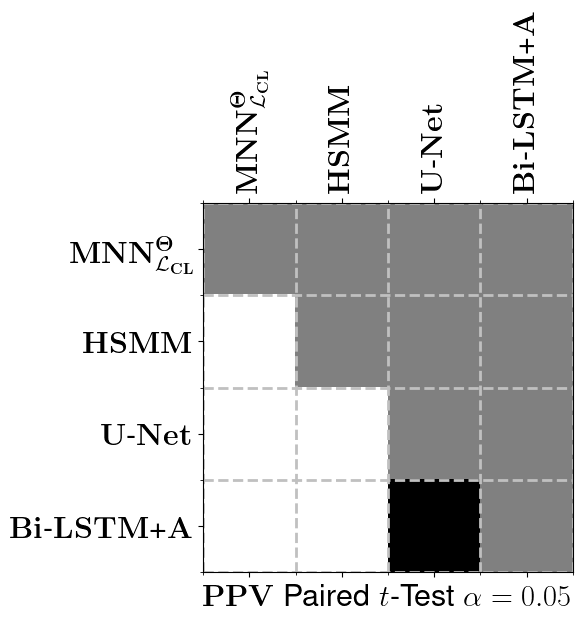

In [21]:
models_circor = {'MNN': circor_nn_only_env_cl,
                'HSMM': [None, circor_hsmm_ppv, circor_hsmm_sens],
'U-Net': circor_unet_cre_env,
             'Fernando': circor_fernando,
             }


ppv = tuple((x, tuple(y[1])) for x, y in models_circor.items())
sens = tuple((x, tuple(y[2])) for x, y in models_circor.items())
    
pairs_ppv, t_stats_ppv, mat_ppv = paired_t_test_statistics(ppv)
ticks = [r'$\mathrm{\mathbf{MNN}}^{\mathbf{\Theta}}_{\mathcal{L}_\mathrm{\mathbf{CL}}}$',
         r'$\mathrm{\mathbf{HSMM}}$', '$\mathbf{U}$-$\mathbf{Net}$', '$\mathbf{Bi}$-$\mathbf{LSTM}$+$\mathbf{A}$']
plot_t_test_matrix(mat_ppv, ticks, '$\mathbf{PPV}$')
plt.savefig('circor_ppv.png', dpi=600, bbox_inches='tight',)

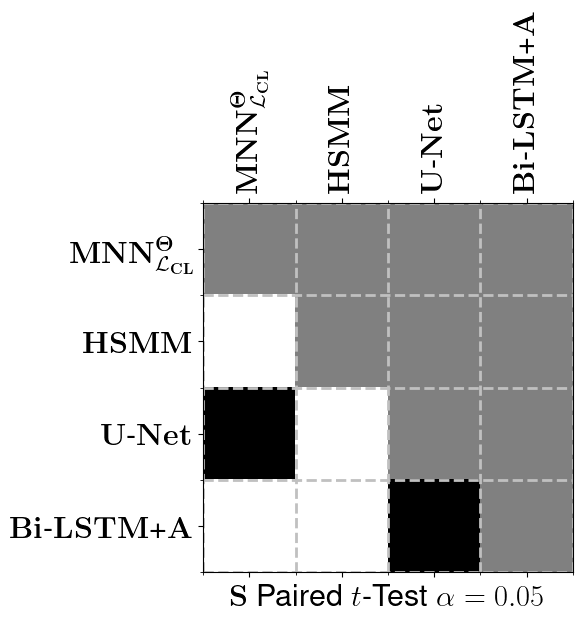

In [22]:
pairs_sens, t_stats_sens, mat_sens = paired_t_test_statistics(sens)
ticks = [r'$\mathrm{\mathbf{MNN}}^{\mathbf{\Theta}}_{\mathcal{L}_\mathrm{\mathbf{CL}}}$',
         r'$\mathrm{\mathbf{HSMM}}$', '$\mathbf{U}$-$\mathbf{Net}$', '$\mathbf{Bi}$-$\mathbf{LSTM}$+$\mathbf{A}$']
plot_t_test_matrix(mat_sens, ticks, '$\mathbf{S}$')
plt.savefig('circor_sens.png', dpi=600, bbox_inches='tight',)

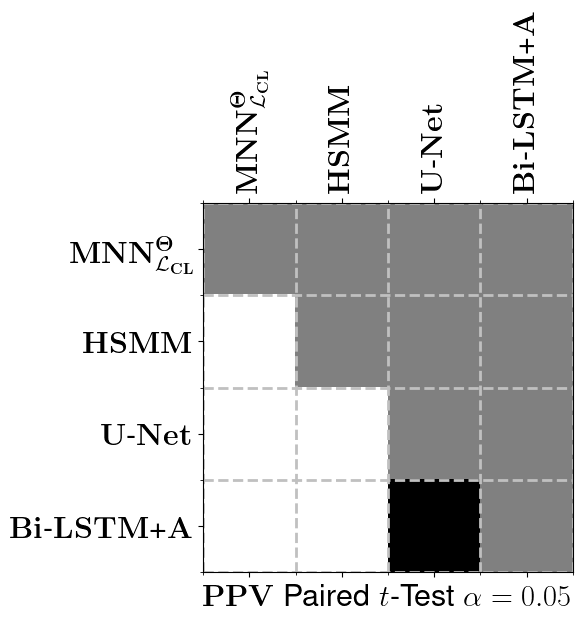

In [27]:
ph16_dict = {'CL-NNOnly': ph16_hmm_nnonly_cl_env,
             'HSMM': [None, ph16_hsmm_ppv, ph16_hsmm_sens],
             'U-NET': ph16_crosse_unet_env,
             'Fernando': ph16_fernando_CE_mfcc}

ppv = tuple((x, tuple(y[1])) for x, y in ph16_dict.items())
sens = tuple((x, tuple(y[2])) for x, y in ph16_dict.items())


pairs_ppv, t_stats_ppv, mat_ppv = paired_t_test_statistics(ppv)

plot_t_test_matrix(mat_ppv, ticks, '$\mathbf{PPV}$')

plt.savefig('ph16-ppv', dpi=600, bbox_inches='tight',)

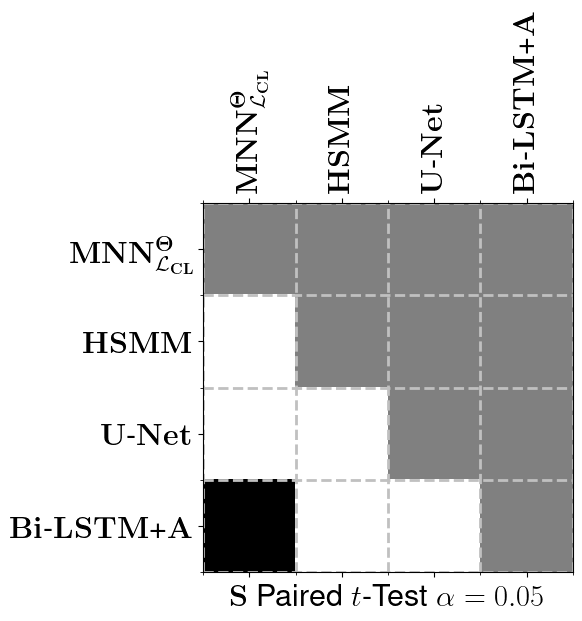

In [26]:
pairs_sens, t_stats_sens, mat_sens = paired_t_test_statistics(sens)

plot_t_test_matrix(mat_sens, ticks, '$\mathbf{S}$')

plt.savefig('ph16-sens', dpi=600, bbox_inches='tight',)